In [39]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

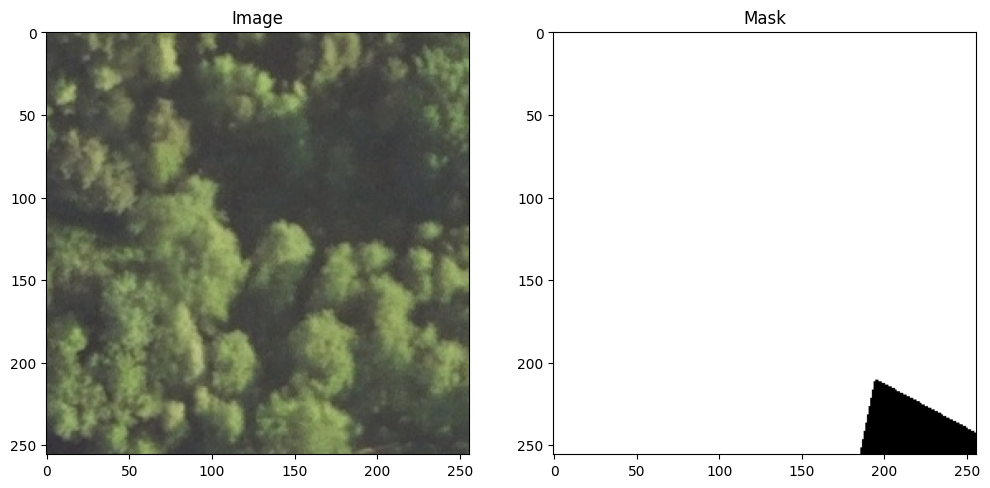

In [40]:
train_img_dir = "/mnt/disk/Data/train_images/train/"
train_mask_dir = "/mnt/disk/Data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [41]:
import os
print(len(os.listdir('/mnt/disk/Data/train_masks/train')))
print(len(os.listdir('/mnt/disk/Data/train_images/train')))
print(len(os.listdir('/mnt/disk/Data/val_masks/val')))
print(len(os.listdir('/mnt/disk/Data/val_images/val')))

16443
16443
5481
5481


In [42]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed=24
batch_size= 16
n_classes=5

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [44]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [45]:
def preprocess_data(img, mask, num_class):
    #Scale images
    # print("Input shape: ",img.shape)
    
    # img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    # print("After Preprocess: ",img.shape)
    mask = to_categorical(mask, num_class)
    # print("Mask: ",mask.shape)
      
    return (img,mask)

In [46]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


In [48]:
train_img_path = "/mnt/disk/Data/train_images/"
train_mask_path = "/mnt/disk/Data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "/mnt/disk/Data/val_images/"
val_mask_path = "/mnt/disk/Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

In [49]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()


Found 16443 images belonging to 1 classes.
Found 16443 images belonging to 1 classes.


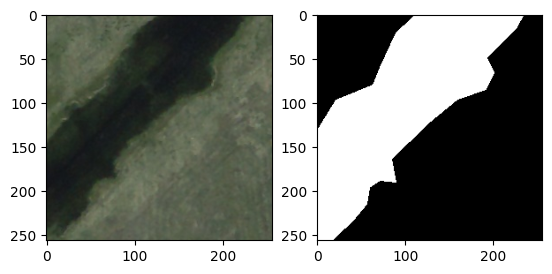

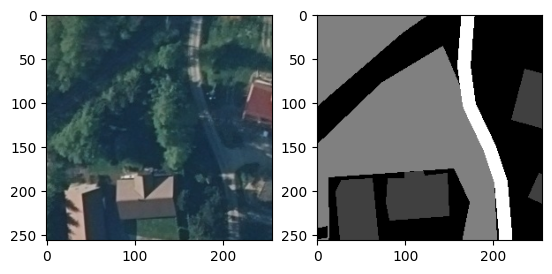

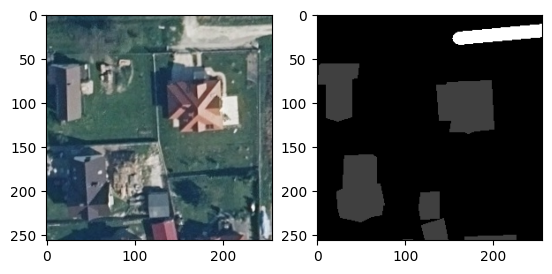

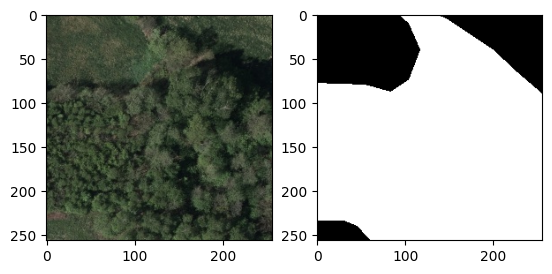

Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.


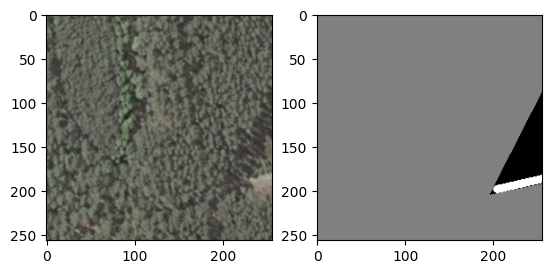

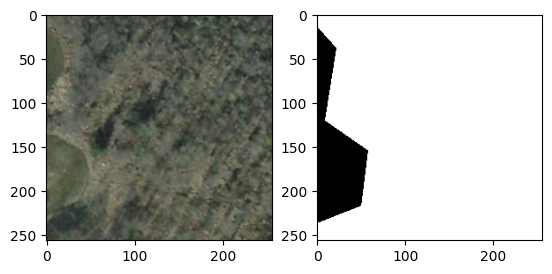

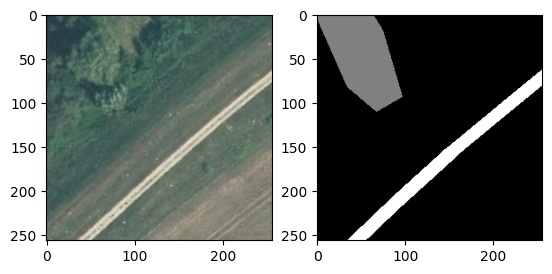

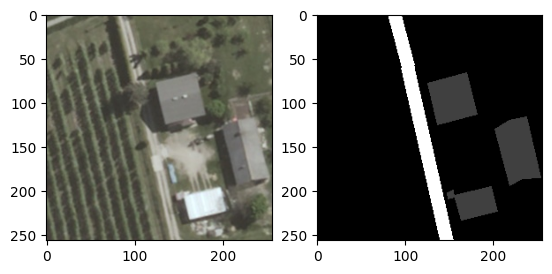

In [50]:
for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,4):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [51]:
###########################################################################
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/mnt/disk/Data/train_images/train/'))
num_val_images = len(os.listdir('/mnt/disk/Data/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

In [52]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [54]:
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='landcover_epoch_{epoch:02d}.hdf5',  # File path to save the model
    save_best_only=True,
    monitor='val_loss',   # Save the model at every epoch
    save_freq='epoch'  # Save the model after every epoch
)


In [53]:
from keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', 
                              monitor='val_loss', 
                              save_best_only=True)

# Assuming model is your compiled Keras model
# model.fit(train_generator, epochs=num_epochs, validation_data=val_generator, callbacks=[checkpoint])


In [55]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
          callbacks=[model_checkpoint])

model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

Epoch 1/25
1027/1027 [==============================] - ETA: 0s - loss: 0.5774 - iou_score: 0.4615

/home/ncit/.anaconda/envs/vfcenv/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1027/1027 [==============================] - 374s 346ms/step - loss: 0.5774 - iou_score: 0.4615 - val_loss: 1.0971 - val_iou_score: 0.1354
Epoch 2/25
1027/1027 [==============================] - 366s 357ms/step - loss: 0.4710 - iou_score: 0.5642 - val_loss: 0.5132 - val_iou_score: 0.5257
Epoch 3/25
1027/1027 [==============================] - 366s 357ms/step - loss: 0.4420 - iou_score: 0.5905 - val_loss: 0.4474 - val_iou_score: 0.5906
Epoch 4/25
1027/1027 [==============================] - 366s 356ms/step - loss: 0.4129 - iou_score: 0.6170 - val_loss: 0.4318 - val_iou_score: 0.6023
Epoch 5/25
1027/1027 [==============================] - 366s 356ms/step - loss: 0.3942 - iou_score: 0.6345 - val_loss: 0.4493 - val_iou_score: 0.5858
Epoch 6/25
1027/1027 [==============================] - 366s 356ms/step - loss: 0.3839 - iou_score: 0.6437 - val_loss: 0.4973 - val_iou_score: 0.5467
Epoch 7/25
1027/1027 [==============================] - 366s 356ms/step - loss: 0.3710 - iou_score: 0.6554 - va

In [56]:

# history=model.fit(train_img_gen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=25,
#           verbose=1,
#           validation_data=val_img_gen,
#           validation_steps=val_steps_per_epoch,
#           callbacks=[model_checkpoint])

# model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')


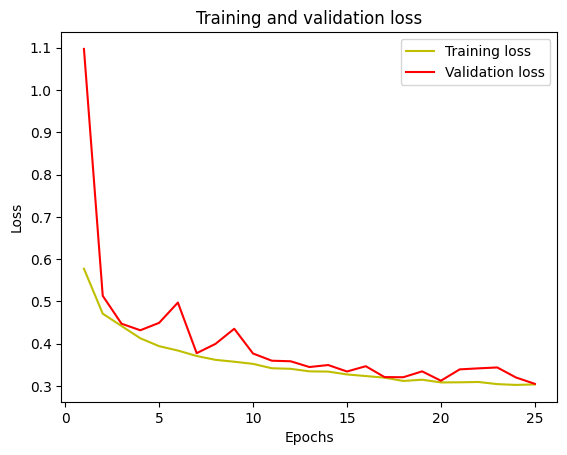

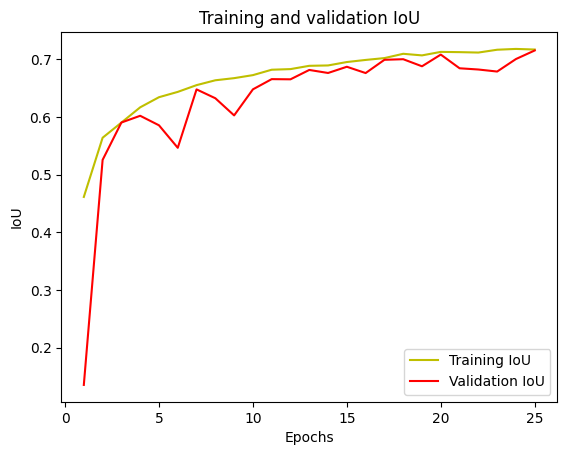

In [57]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [77]:
from keras.models import load_model
import segmentation_models as sm
from keras.utils import get_custom_objects

# custom_objects = {
#     'categorical_focal_jaccard_loss': sm.losses.categorical_focal_jaccard_loss
# }

# Assuming 'landcover_25_epochs_RESNET_backbone_batch16.hdf5' includes optimizer state
model = load_model('landcover_25_epochs_RESNET_backbone_batch16.hdf5',custom_objects={'categorical_focal_jaccard_loss': sm.losses.categorical_focal_jaccard_loss})

# Compile the model (you don't need to redefine optimizer, it will be restored)
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


ValueError: Unknown loss function: 'focal_loss_plus_jaccard_loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [59]:
#####################################################

from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 1s 749ms/step
Mean IoU = 0.8130599


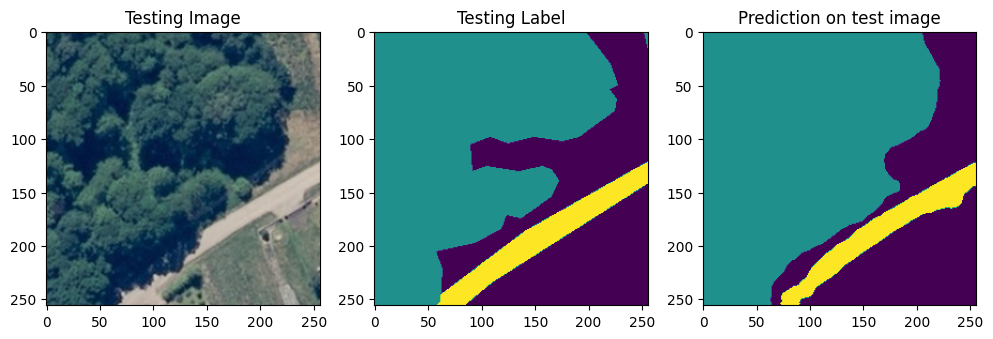

In [70]:
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()